# MASTML

In [128]:
import pickle
import numpy as np
import pandas as pd
import itertools
from mastml.mastml import Mastml
from mastml.feature_generators import ElementalFeatureGenerator, ElementalFractionGenerator
import matplotlib.pyplot as plt
import random
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.models import SklearnModel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern, ConstantKernel
import time

## Load Data

In [129]:
pfile_X = "Codes/bandgap_pbe_X.pickle"
pfile_Y = "Codes/bandgap_pbe_Y.pickle"

# LOAD DATA
with open(pfile_X, 'rb') as f:
    data = pickle.load(f)
with open(pfile_Y, 'rb') as f:
    data_y = pickle.load(f)

# PARSE DATA
x_clean = data[['composition', 'structure', 'space group']]
compositions = x_clean['composition']
# structure = x_clean['structure']
print("num compositions", len(compositions))

num compositions 74992


## Functions

In [130]:

def create_subset(sample_from, n = 1000):
    subset_compositions, subset_y = zip(*random.sample(sample_from, n))
    subset_x = pd.DataFrame(subset_compositions)
    return subset_x, subset_y

def vectorize(x_compositions, y):
    e_features = ElementalFeatureGenerator(x_compositions)
    e_features.fit()

    feat_x, feat_y = e_features.transform()

    x = feat_x
    y = subset_y

    # Scale
    preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)
    x = preprocessor.evaluate(X=x, y=y)

    return x, y

def compute_elemetal_fractions(x_compositions):
    e_fraction = ElementalFractionGenerator(x_compositions)
    e_fraction.fit()
    frac_x, frac_y = e_fraction.transform() # only used to create domains later
    return frac_x, frac_y

def featurize(x):
    model = SklearnModel(model='RandomForestRegressor')
    selector = EnsembleModelFeatureSelector(model=model, n_features_to_select=25)
    x = selector.evaluate(X=x, y=y)
    return x

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def showScores(x, y, y_, gpr):
    """Show evaluation metrics given `x`, `y`, and predicted y, `y_` and GPR model `gpr`"""
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    max_val = max(max(y), max(y_))
    ax.plot([0, max_val], [0, max_val])
    plt.show()

    max_val = max(max(y), max(y_))
    fig, ax = plt.subplots()
    ax.scatter(x=y, y=y_)
    ax.set_xlim((0, max_val))
    ax.set_ylim((0, max_val))
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1-x0)/abs(y1-y0))
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.show()

    r2_score = gpr.score(x, y)
    print(f"R^2 score: {r2_score}")
    err = rmse(y, y_) / np.std(y)
    print(f"R^2 score / std: {err}")

## One Run

In [131]:
# subset n random values
comp_zip_y = list(zip(compositions, data_y.T.values.tolist()[0]))

subset_x, subset_y = create_subset(comp_zip_y)

In [132]:
# Vectorize
x, y = vectorize(subset_x, subset_y)

# check that the y is reasonable
# plt.hist(y)
# plt.show()

Dropping 5/440 generated columns due to missing values


In [133]:
# Featurize
x = featurize(x)

In [134]:
## Fit GPR

gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)

print("Start fitting")
stime = time.time()

gpr.fit(x, y)

print("Done. Time for GPR fitting: %.3f" % (time.time() - stime))

Start fitting
Done. Time for GPR fitting: 53.417


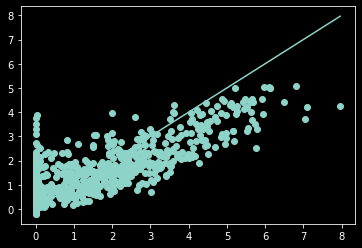

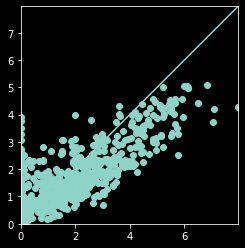

R^2 score: 0.6914123806625048
R^2 score / std: 0.5555066330274511


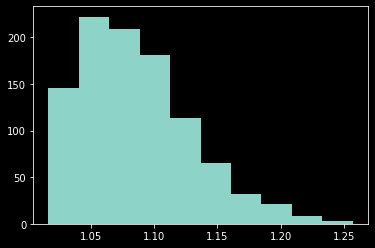

In [135]:
## Predict and score

y_, std_ = gpr.predict(x, return_std=True)

showScores(x, y, y_, gpr)

_ = plt.hist(std_)
plt.show()

## Domain Assesment

In [136]:
# Split x and y by domains using frac_x
pass

## OLD CODE

In [137]:
# # list(x.items())
# # print(*x.items(), sep="\n")
# # print(x.iloc[0])

# ## verify rows sum to 1
# # total = x.sum(axis=1, numeric_only= True)
# # print("total", total)

# # material_group_char = ["O", "B", "F", "Cl", "Br", "I"]
# material_group_char = ["O"]
# thresholds = [0]
# for mat in material_group_char:
#     continue
#     print("Grouping for", mat)
#     st1 = 100
#     st2 = 10

#     for th in thresholds:
#         # Make split
#         group_X = x[x[mat] > th]
#         not_group_X = x[x[mat] <= th]
#         # group_y = [None for x in group_X]
#         # not_group_y = [None for x in not_group_y]
#         group_y = y[x[mat] > th]
#         not_group_y = y[x[mat] <= th]

#         perc_in_group = group_X.shape[0]/x.shape[0]
#         print(f"\ttheshold:\t{th}\n\tpercent in {mat}_group:\t{perc_in_group}")
#         # if the split leaves an empty group skip
#         if perc_in_group == 0:
#             continue

#         # group_X.iloc(100)
#         group_X = np.array(group_X)
#         group_y = np.array(group_y)

#         group_X = group_X[0:1000,:]
#         group_y = group_y[0:1000,:]
        
#         # do GPR stuff
#         print(f"Doing GPR for {mat}")
#         # gp_kernel = ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1)) + WhiteKernel(1e-1) 
#         gp_kernel = ConstantKernel() * Matern() + WhiteKernel()
#         gpr = GaussianProcessRegressor(kernel=gp_kernel, n_restarts_optimizer=10)
#         print("gpr:", gpr)
#         # break
#         stime = time.time()
#         print("Start fitting")
#         # gpr.fit(group_X, group_y)
#         print("Time for GPR fitting: %.3f" % (time.time() - stime))
#         print("Done")

#         x_, std_ = gpr.predict(group_X, return_std=True)
#         print("x_", x_)
#         print("std_", std_)

#         # Predict using gaussian process regressor
#         # stime = time.time()
#         # y_gpr = gpr.predict(X_plot, return_std=False)
#         # print("Time for GPR prediction: %.3f" % (time.time() - stime))

# # gpr.kernel_
# # np.std(group_X)